# 2-アニーリングアルゴリズムの評価

アニーリングアルゴリズムはヒューリスティクスの一つなので毎回最適解を出せるとは限りません。近似解を出すためのアルゴリズムです。
また、確率的アルゴリズムなので毎回解が異なります。  
そのためアルゴリズムの評価をする際は様々な平均値を持って解を評価します。よく用いられる手法が

- 成功確率 or エラー確率
- TTS : Time to solution
- 残留エネルギー : Resudial energy

の3つです。特にTTSは計算時間を表すので評価としてよく用いられます。残留エネルギーは最適解にどれくらい近づけたかを平均的に示す値です。
まず、TTSから見ていきましょう。

## Time to solution

TTS は計算時間を表しますが、アニーリングアルゴリズムはどの計算時間でも何かしらの解を出すことができるので計算時間といってもただ計算時間を測るのではなく、何かしら別の指標が必要です。安直に思いつくのはある確率以上で解がでるために必要な計算時間です。しかし、"1-Introduction"でも行なったようにアニーリングアルゴリズムは複数回行って解を探すため、計算時間を評価するには複数回行うことも考慮に入れなければなりません。

そこで複数回アニーリングを行うことも考慮に入れたのがTime to solution(TTS)です。TTSは簡単に導くことができます。

ここで1回のアニーリング時間を$\tau$とし、1回の$\tau$時間のアニーリングで最適解を得る確率を$p_s(\tau)$としましょう(sはsuccessです)。  
すると$R$回$\tau$時間のアニーリングを行って1回でも最適解を得る確率$p_R$は

$$p_R = 1-(1-p_s(\tau))^R$$

となります。第二項は$R$回やっても最適解を得られない(間違える)確率なのでそれを1から引けば$R$回やって最適解を得られる確率になります。
この式を$R$について解きましょう。すると

$$R = \frac{\ln(1-p_R)}{\ln(1-p_s(\tau))}$$

となります。これに1回の計算時間$\tau$をかけるとトータルの計算時間となるのでそれがTime to solution (TTS)です。

$$TTS(\tau, p_R) = \tau R = \tau \frac{\ln(1-p_R)}{\ln(1-p_s(\tau))}$$

$TTS(\tau, p_R)$が示すのは計算時間が$\tau$の一回のアニーリングで確率$p_s(\tau)$で最適解が得られる時、確率$p_R$で最適解が得られるまでの繰り返し回数も考慮した総計算時間になります。

実際の計算の評価では、$p_R$を定数で与えます。$p_R=0.99$などにすることが多いかと思います。そして様々なアニーリング時間$\tau$で$p_s(\tau)$を計算して、それらを使って$TTS(\tau, p_R)$を計算します。

### OpenJij で実験を行ってTTSを測る

では以下では実際にOpenJijを使ってTTSを図ってみましょう。  
1次元反強磁性モデルという問題を考えます。
1次元反強磁性イジングモデルというのは以下のエネルギーです。

$$H(\{\sigma_i\}) = \sum_{i=0}^{N-1} J_{i, i+1}\sigma_i \sigma_{i+1} + \sum_{i=0}^{N-1} h_i \sigma_i$$

ここで$J_{ij} \in [0.1, 1.0]$とし、$h_0 = -1$で他の縦磁場は0とします。$J_{ij} > 0$(反強磁性)なので各スピンは違う向きに向いた方がエネルギーが下がります。なので最適解となる$\{\sigma_i\}$は$1, -1, 1,\cdots$ のように値が交互になります。また$h_0=-1$としているので、最初のスピンは$\sigma_0 =1$になります。よって最適解は $1, -1, 1, \cdots$です。

つまり$TTS$は$1, -1, 1, \cdots$を得るためにかかる総計算時間となります。  
以下では上記のIsing モデルをといて、1回の計算時間を延ばすとTTSがどう変化するかを見てみましょう。

In [1]:
#!pip install -U cmake
#!pip install openjij
!pip show openjij  # openjij == 0.0.8 を仮定します

Name: openjij
Version: 0.0.5
Summary: Framework for ising model and QUBO
Home-page: https://openjij.github.io/OpenJij/
Author: Jij Inc.
Author-email: openjij@j-ij.com
License: Apache License 2.0
Location: /usr/local/miniconda3/lib/python3.6/site-packages
Requires: requests, numpy
Required-by: 


In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import openjij as oj

In [3]:
# 反強磁性1次元イジングモデル を作る.
N = 30
h = {0: -10}
J = {(i, i+1): 1 for i in range(N-1)}

## TTSを計算してみる

TTSを計算してみます。openjijのsample_isingまたはsample_qubo から返ってくる Response クラスは `info` というメンバ変数を持っています。  
`info`にはsamplerごとに異なった情報が辞書型で格納されています。ほとんどのSamplerには `['execution_time']`という名前で各アルゴリズムの1回の実行時間 (μs) が格納されています。  

SASampler の場合は Simulated annealing の1回あたりの計算時間を格納しています。

In [4]:
# 最適解
correct_state = [(-1)**i for i in range(N)]

# TTS を計算するのに必要なp^R
pR = 0.99

# Samplerの引数のstep_num というパラメータに渡すリスト(step_num_list) 
# step_num はアニーリング中のパラメータ(温度, 横磁場)を下げていくときの分割数
# なので増やせば増やすほどゆっくりアニーリングすることになってアニーリング時間が伸びる。
step_num_list = [10, 20, 30, 40]

# 各計算時間に対するTTSを格納しておくリスト
TTS_list = []
tau_list = []  # 計算時間を格納しておくリスト

iteration = 2000  # 確率を計算するために1回のアニーリングを行う回数

for step_num in step_num_list:
    # beta_max と　beta_min はSAのアルゴリズムで使うパラメータ.
    # 確率p_sを計算するために500回計算する
    sampler = oj.SASampler(beta_max=10.0, beta_min=0.01, step_num=step_num, iteration=iteration)  
    
    response = sampler.sample_ising(h, J)
    # 返ってきた解であっている状態の数を数えて最適解を得た確率を計算する。
    tau = response.info['execution_time']
    ps = sum([1 if state == correct_state else 0 for state in response.states])/iteration
    
    # ps=0だとTTSが無限大になってしまうのでそこは回避
    if ps == 0:
        continue
    
    # TTSを計算する
    TTS_list.append(np.log(1-pR)/np.log(1-ps)*tau)
    tau_list.append(tau)

Text(0, 0.5, 'TTS')

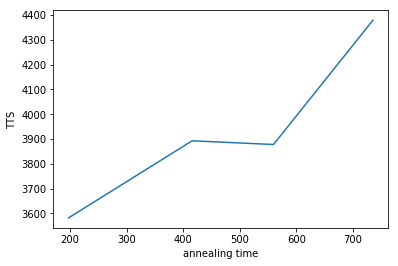

In [5]:
plt.plot(tau_list, TTS_list)
plt.xlabel('annealing time')
plt.ylabel('TTS')

1回あたりの計算時間がブレてしまいますが、とりあえず計算することができました。
ちなみにOpenJijにはデフォルトでTTS, 残留エネルギー, エラー確率を評価してくれる関数が付いています。

``openjij.benchmark``
です。

## benchmark 関数

benchmark 関数では TTSと残留エネルギー、エラー確率を計算してくれます。

引数は以下です

- true_ground_states: list(list: state)  
    基底状態となる状態のリストです。 縮退している場合は[state1, state2]のようにして複数入れます。
- ground_energy: float  
    基底状態のエネルギーを入力します。
- solver: function  
    Response クラスを返す関数です。関数は time_param と iteration という引数を持つ必要があります。
    time_param は計算時間を制御するパラメータにしてください。SASamplerの場合は step_num に相当します。
    iteration は TTSや残留エネルギーなどを計算するときに必要なサンプリング回数を指定します。
    また 関数の戻り値のResponse.info には、`time_name`という引数で指定する文字列をキーワードで持ち、`time_name`に紐づく値は1回あたりの計算時間が格納されている必要があります。
- time_param_list: list  
    solver の time_param 引数に入れる値のリストです。
- p_d: 0 < float <= 1  
    TTSを計算するために必要な値です。上記のTTSの説明のp_R に相当します。
- iteration: int  
    TTSなどで平均値を計算するためのサンプリング数
- time_name: str  
    Response.info に入っている実行時間と紐づくキーを指定します。デフォルトは`"execution_time"`です。
    
返り値はbenchmark計算の結果が辞書型で格納されています。

In [6]:
result = oj.benchmark(
                      true_ground_states=[correct_state], ground_energy=0, 
                      solver= lambda time_param, iteration: oj.SASampler(step_num=time_param, iteration=iteration).sample_ising(h,J),
                      time_param_list=step_num_list,
                      p_d=0.99
            )

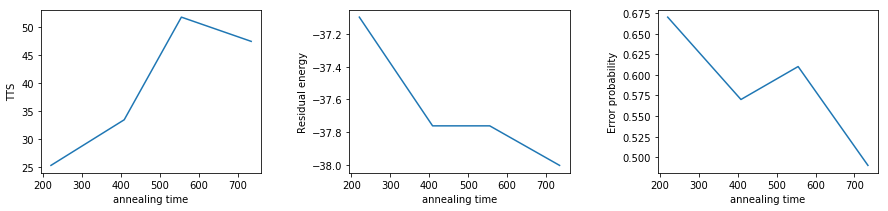

In [8]:
fig, (axL,axC,axR) = plt.subplots(ncols=3, figsize=(15,3))
plt.subplots_adjust(wspace=0.4)

fontsize = 10
axL.plot(result['time'], result['tts'])
axL.set_xlabel('annealing time', fontsize=fontsize)
axL.set_ylabel('TTS', fontsize=fontsize)

axC.plot(result['time'], result['e_res'])
axC.set_xlabel('annealing time', fontsize=fontsize)
axC.set_ylabel('Residual energy', fontsize=fontsize)

axR.plot(result['time'], result['error'])
axR.set_xlabel('annealing time', fontsize=fontsize)
axR.set_ylabel('Error probability', fontsize=fontsize)

fig.show()

このようにして簡単にベンチマークをとることができます。solver に入れる関数は Responseクラスを返して、.info に計算時間を格納しておけばどのような関数でもよいです。適当なやつを作ってみましょう。

In [9]:
import time 
def anti_ferro_solver(time_param, iteration, h, J):
    """
    すべて 1 と [1,-1,1,...] と [-1,1,-1,...] の3つの状態からランダムに選ぶ
    """
    
    # 入力された h と J から添字の集合をつくる
    indices = set(h.keys())
    indices = list(indices | set([key for keys in J.keys() for key in keys]))
    
    ones_state = list(np.ones(len(indices), dtype=int))        # all 1
    
    minus_plus_state = np.ones(len(indices), dtype=int)
    minus_plus_state[::2] *= -1                                         # -1, 1, -1, 1, ...
    plus_minus_state = -1 * minus_plus_state                   # 1, -1, 1, -1
    
    start = time.time()
    _states = [ones_state, list(minus_plus_state), list(plus_minus_state)]
    state_record = [_states[np.random.randint(3)] for _ in range(iteration)]   # 3つの状態からランダムにひとつ選ぶ
    exec_time = (time.time()-start) * 10**6 * time_param                                # 適当に計算時間を伸ばしておきます
    
    energies = [sum(state) for state in state_record]                                     # エネルギーの計算はてきとうです
    
    
    # Responseクラスに状態とエネルギーを格納します
    response = oj.Response(indices=indices, var_type='SPIN')
    response.update_ising_states_energies(state_record, energies)
    response.info['execution_time'] = exec_time
    
    return response
        

In [10]:
result = oj.benchmark(
                      true_ground_states=[correct_state], ground_energy=0, 
                      solver= lambda time_param, iteration: anti_ferro_solver(time_param, iteration, h, J),
                      time_param_list=step_num_list,
                      iteration=100,
                      p_d=0.99
            )

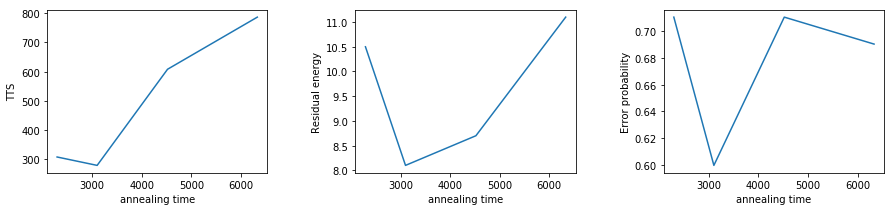

In [11]:
fig, (axL,axC,axR) = plt.subplots(ncols=3, figsize=(15,3))
plt.subplots_adjust(wspace=0.4)

fontsize = 10
axL.plot(result['time'], result['tts'])
axL.set_xlabel('annealing time', fontsize=fontsize)
axL.set_ylabel('TTS', fontsize=fontsize)

axC.plot(result['time'], result['e_res'])
axC.set_xlabel('annealing time', fontsize=fontsize)
axC.set_ylabel('Residual energy', fontsize=fontsize)

axR.plot(result['time'], result['error'])
axR.set_xlabel('annealing time', fontsize=fontsize)
axR.set_ylabel('Error probability', fontsize=fontsize)

fig.show()

3つからランダムにひとつ選んで1つ正解の状態を選んでいるのでエラー確率は大体2/3くらいなので左図も大体それくらいになっています。

このようにうまくsolver関数を作っておけばOpenJijのソルバーに限らず TTSと残留エネルギーとエラー確率を計算してくれます。  